In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression


def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 0))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X


def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data


calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

print(len(subjects), subjects)
print("average number of runs:", np.mean(list(subjects_runs.values())),
      "+-", np.std(list(subjects_runs.values())))

18 ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']
average number of runs: 7.388888888888889 +- 3.0393509703533175


In [2]:
mocet_calibration_errors = {}
mocet_validation_errors = {}

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not mocet_calibration_errors.keys().__contains__(subject):
                    mocet_calibration_errors[subject] = []
                    mocet_validation_errors[subject] = []

                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                # log, data, confound, start
                pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
                    log_fname,
                    data_fname,
                    start=start,
                    duration=task_duration)
                pupil_data = mocet.apply_mocet(pupil_data=pupil_data_new,
                                               motion_params_fname=confounds_fname,
                                               pupil_confidence=pupil_confidence,
                                               large_motion_params=False,
                                               polynomial_order=3)

                t_cal = 0
                t_val = 1

                offset = calibration_onsets[t_cal]
                calibration_pupils = []
                for i in np.arange(calibration_points[t_cal]):
                    start = (offset + i) * interval + calibration_offset_start
                    end = (offset + i + 1) * interval + calibration_offset_end
                    log_effective = np.logical_and(pupil_timestamps >= start * 1000, pupil_timestamps < end * 1000)
                    calibration_pupils.append([np.nanmean(pupil_data[log_effective, 0]),
                                               np.nanmean(pupil_data[log_effective, 1])])
                calibration_pupils = np.array(calibration_pupils)

                repeat = True if calibration_points[t_cal] == 24 else False
                calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                          calibration_order=calibration_order,
                                                          repeat=repeat)
                calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                gaze_coordinates = calibrator.transform(pupil_data)

                for t in [t_cal, t_val]:
                    MSE = []
                    offset = calibration_onsets[t]
                    for i in np.arange(calibration_points[t]):
                        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                        start = (offset + i) * interval + calibration_offset_start
                        end = (offset + i + 1) * interval + calibration_offset_end
                        gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                        gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                        eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                        if np.any(~eye_closed):
                            data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                            data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                            MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                    if t == t_cal:
                        calibration_error = np.nanmean(MSE) / px_per_deg
                        mocet_calibration_errors[subject].append(calibration_error)
                    elif t == t_val:
                        validation_error = np.nanmean(MSE) / px_per_deg
                        mocet_validation_errors[subject].append(validation_error)
                print(key, calibration_error, validation_error)
subjects_mocet_calibration_errors = []
subjects_mocet_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_mocet_calibration_errors.append(np.mean(mocet_calibration_errors[key], axis=0))
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[key], axis=0))

print(np.mean(subjects_mocet_calibration_errors), np.mean(subjects_mocet_validation_errors))
with open(f'../../data/error/mocet_calibration_error.pkl', 'wb') as f:
    pickle.dump(mocet_calibration_errors, f)
with open(f'../../data/error/mocet_validation_error.pkl', 'wb') as f:
    pickle.dump(mocet_validation_errors, f)

('sub-003', 'ses-07R', 'task-mcHERDING', 'run-1') 0.2876526923405421 1.1658783216865674
('sub-003', 'ses-07R', 'task-mcHERDING', 'run-2') 0.2197042026822146 1.0892272594891899
('sub-003', 'ses-07R', 'task-mcHERDING', 'run-3') 0.3450303234082087 1.0466041774804977
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-1') 0.543262610276934 1.0014503544136413
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-2') 0.3665839925486996 1.1534805876078498
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-3') 0.37886668868975737 0.8403276024664789
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-4') 0.41848800693371957 0.8116125012141009
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-5') 0.2923334245922819 1.072436458886888
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-7') 0.9999805576040579 1.8457706145446116
('sub-004', 'ses-07R', 'task-mcHERDING', 'run-1') 0.49039622842159925 1.5992443399081855
('sub-004', 'ses-07R', 'task-mcHERDING', 'run-2') 0.34164810444568205 1.9409812955822245
('sub-004', 'ses-07R', 'task-m

In [10]:
for p in range(1, 13):
    polynomial_calibration_errors = {}
    polynomial_validation_errors = {}

    for subject in subjects:
        sessions = subject_pool[subject].keys()
        for session in sessions:
            runs = subject_pool[subject][session]
            root = f'{project_dir}/data/eyetracking/{subject}/{session}'
            for r in runs:
                run = f'run-{r}'
                np.random.seed(0)
                key = (subject, session, task, run)
                if key in valid_data.keys():
                    if not polynomial_calibration_errors.keys().__contains__(subject):
                        polynomial_calibration_errors[subject] = []
                        polynomial_validation_errors[subject] = []

                    log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                    data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                    confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                    history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                    start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                    # log, data, confound, start
                    pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
                                                                                            log_fname,
                                                                                            data_fname,
                                                                                            start=start,
                                                                                            duration=task_duration)
                    pupil_data = polynomial_detrending(pupil_data,
                                                       polynomial_order=p)

                    t_cal = 0
                    t_val = 1

                    offset = calibration_onsets[t_cal]
                    calibration_pupils = []
                    for i in np.arange(calibration_points[t_cal]):
                        start = (offset + i) * interval + calibration_offset_start
                        end = (offset + i + 1) * interval + calibration_offset_end
                        log_effective = np.logical_and(pupil_timestamps >= start * 1000, pupil_timestamps < end * 1000)
                        calibration_pupils.append([np.nanmean(pupil_data[log_effective, 0]),
                                                   np.nanmean(pupil_data[log_effective, 1])])
                    calibration_pupils = np.array(calibration_pupils)

                    repeat = True if calibration_points[t_cal] == 24 else False
                    calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                              calibration_order=calibration_order,
                                                              repeat=repeat)
                    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                    gaze_coordinates = calibrator.transform(pupil_data)

                    for t in [t_cal, t_val]:
                        MSE = []
                        offset = calibration_onsets[t]
                        for i in np.arange(calibration_points[t]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset + i) * interval + calibration_offset_start
                            end = (offset + i + 1) * interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        if t == t_cal:
                            calibration_error = np.nanmean(MSE) / px_per_deg
                            polynomial_calibration_errors[subject].append(calibration_error)
                        elif t == t_val:
                            validation_error = np.nanmean(MSE) / px_per_deg
                            polynomial_validation_errors[subject].append(validation_error)
    with open(f'../../data/error/polynomial_calibration_error_p{p:02d}.pkl', 'wb') as f:
        pickle.dump(polynomial_calibration_errors, f)
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}.pkl', 'wb') as f:
        pickle.dump(polynomial_validation_errors, f)

    subjects_polynomial_calibration_errors = []
    subjects_polynomial_validation_errors = []
    for key in mocet_calibration_errors.keys():
        subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subjects_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[key], axis=0))

    print(p, np.mean(subjects_polynomial_calibration_errors), np.mean(subjects_polynomial_validation_errors))

1 0.4362010943742307 5.81605242811512
2 0.4407116401565119 5.849214994945073
3 0.4758893207229332 2.826476910197833
4 0.5066498098667118 2.633156224322112
5 0.5450937078139638 1.725369399400716
6 0.5474927950726358 1.8090963954041632
7 0.5343363594755376 1.673969996921935
8 0.5766309397915839 1.6630301991003875
9 0.5623250486783512 1.6860242475283875
10 0.5608469577421795 1.625402812914989
11 0.5303207883483121 1.7050215029377385
12 0.5252917310095946 1.6981389509962175


In [4]:
### Uncorrected Calibration and Validation Errors
uncorrected_calibration_errors = {}
uncorrected_validation_errors = {}
for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not uncorrected_calibration_errors.keys().__contains__(subject):
                    uncorrected_calibration_errors[subject] = []
                    uncorrected_validation_errors[subject] = []

                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                        data_fname,
                                                                                                        start=start,
                                                                                                        duration=task_duration)
                t_cal = 0
                t_val = 1

                offset = calibration_onsets[t_cal]
                calibration_pupils = []
                for i in np.arange(calibration_points[t_cal]):
                    start = (offset+i)*interval + calibration_offset_start
                    end = (offset+i+1)*interval + calibration_offset_end
                    log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                    calibration_pupils.append([np.nanmean(pupil_data[log_effective,0]),
                                               np.nanmean(pupil_data[log_effective,1])])
                calibration_pupils = np.array(calibration_pupils)

                repeat = True if calibration_points[t_cal] == 24 else False
                calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                          calibration_order = calibration_order,
                                                          repeat=repeat)
                calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                gaze_coordinates = calibrator.transform(pupil_data)

                for t in [t_cal, t_val]:
                    MSE = []
                    offset = calibration_onsets[t]
                    for i in np.arange(calibration_points[t]):
                        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                        start = (offset+i)*interval + calibration_offset_start
                        end = (offset+i+1)*interval + calibration_offset_end
                        gaze_idx_start = np.min(np.where(pupil_timestamps >= start*1000)[0])
                        gaze_idx_end = np.min(np.where(pupil_timestamps >= end*1000)[0])
                        eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                        if np.any(~eye_closed):
                            data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,0][~eye_closed])
                            data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,1][~eye_closed])
                            MSE.append(np.sqrt((ref_x-data_x)**2 + (ref_y-data_y)**2))
                    if t == t_cal:
                        calibration_error = np.nanmean(MSE)/px_per_deg
                        uncorrected_calibration_errors[subject].append(calibration_error)
                    elif t == t_val:
                        validation_error = np.nanmean(MSE)/px_per_deg
                        uncorrected_validation_errors[subject].append(validation_error)

subjects_uncorrected_calibration_errors = []
subjects_uncorrected_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_uncorrected_calibration_errors.append(np.mean(uncorrected_calibration_errors[key], axis=0))
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[key], axis=0))

print(np.mean(subjects_uncorrected_calibration_errors), np.mean(subjects_uncorrected_validation_errors))

with open(f'../../data/error/uncorrected_calibration_error.pkl', 'wb') as f:
    pickle.dump(uncorrected_calibration_errors, f)
with open(f'../../data/error/uncorrected_validation_error.pkl', 'wb') as f:
    pickle.dump(uncorrected_validation_errors, f)

0.4344639014620091 7.237824763820151


(4, 18)


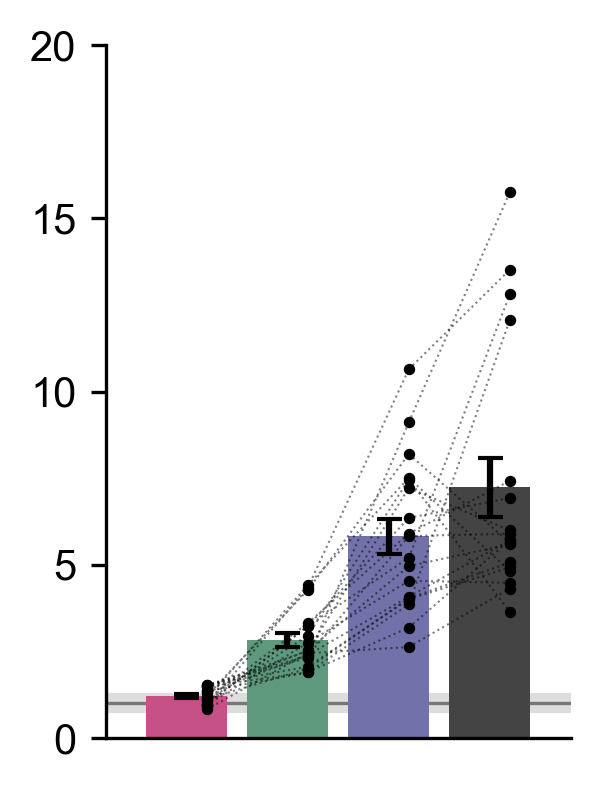

In [2]:
with open(f'../../data/error/mocet_validation_error.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for subject in subjects:
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[subject], axis=0))

with open(f'../../data/error/uncorrected_validation_error.pkl', 'rb') as f:
    uncorrected_validation_errors = pickle.load(f)
subjects_uncorrected_validation_errors = []
for subject in subjects:
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[subject], axis=0))

subjects_polynomial_validation_errors = []
for p in [1,3]:
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)
    #subjects_polynomial_calibration_errors = []
    subject_polynomial_validation_errors = []
    for subject in subjects:
        #subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subject_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[subject], axis=0))
    subjects_polynomial_validation_errors.append(subject_polynomial_validation_errors)


from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

# Define the tags for the errors
tags = ['mocet', 'polynomial', 'linear', 'uncorrected']

MSE_matrix = np.concatenate([
    np.array(subjects_mocet_validation_errors).reshape(1,-1),
    np.flip(np.array(subjects_polynomial_validation_errors), axis=0),
    np.array(subjects_uncorrected_validation_errors).reshape(1,-1)
], axis=0)
print(MSE_matrix.shape)

#color_list = ['#c55187']+['#5e997d']*3+['#444444']
color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

fig, ax = plt.subplots(1, 1, figsize=(2,3), dpi=300,  sharex=True)
beh_mean = 1.006490026230591
beh_std = 0.22859661540266055
ax.axhspan(beh_mean-beh_std, beh_mean+beh_std, color='#dddddd', zorder=0)
ax.axhline(beh_mean, c='#777777', zorder=1, lw=0.8)

ax.bar(np.arange(1+2+1),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(1+2+1):
    ax.scatter(np.ones(len(subjects_mocet_validation_errors)) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(len(subjects_mocet_validation_errors)):
    for i in range(1+2):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 3.8)
ax.set_yticks([0, 5, 10, 15, 20])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [3]:
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[1]))
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[2]))
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[3]))

TtestResult(statistic=np.float64(-7.144460561509467), pvalue=np.float64(1.6427028438840614e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-8.857311573942134), pvalue=np.float64(8.886567022230781e-08), df=np.int64(17))
TtestResult(statistic=np.float64(-7.022179299615635), pvalue=np.float64(2.0530867053360237e-06), df=np.int64(17))


In [4]:
beh = [np.float64(1.504520679043809), np.float64(0.7827702129754451), np.float64(0.4876484483657408), np.float64(1.2510207645373688)]

from scipy.stats import ttest_ind

print(ttest_ind(subjects_mocet_validation_errors, beh))

TtestResult(statistic=np.float64(1.3404461980528781), pvalue=np.float64(0.19512953850607537), df=np.float64(20.0))


In [5]:
len(valid_data)

133

(14, 18)


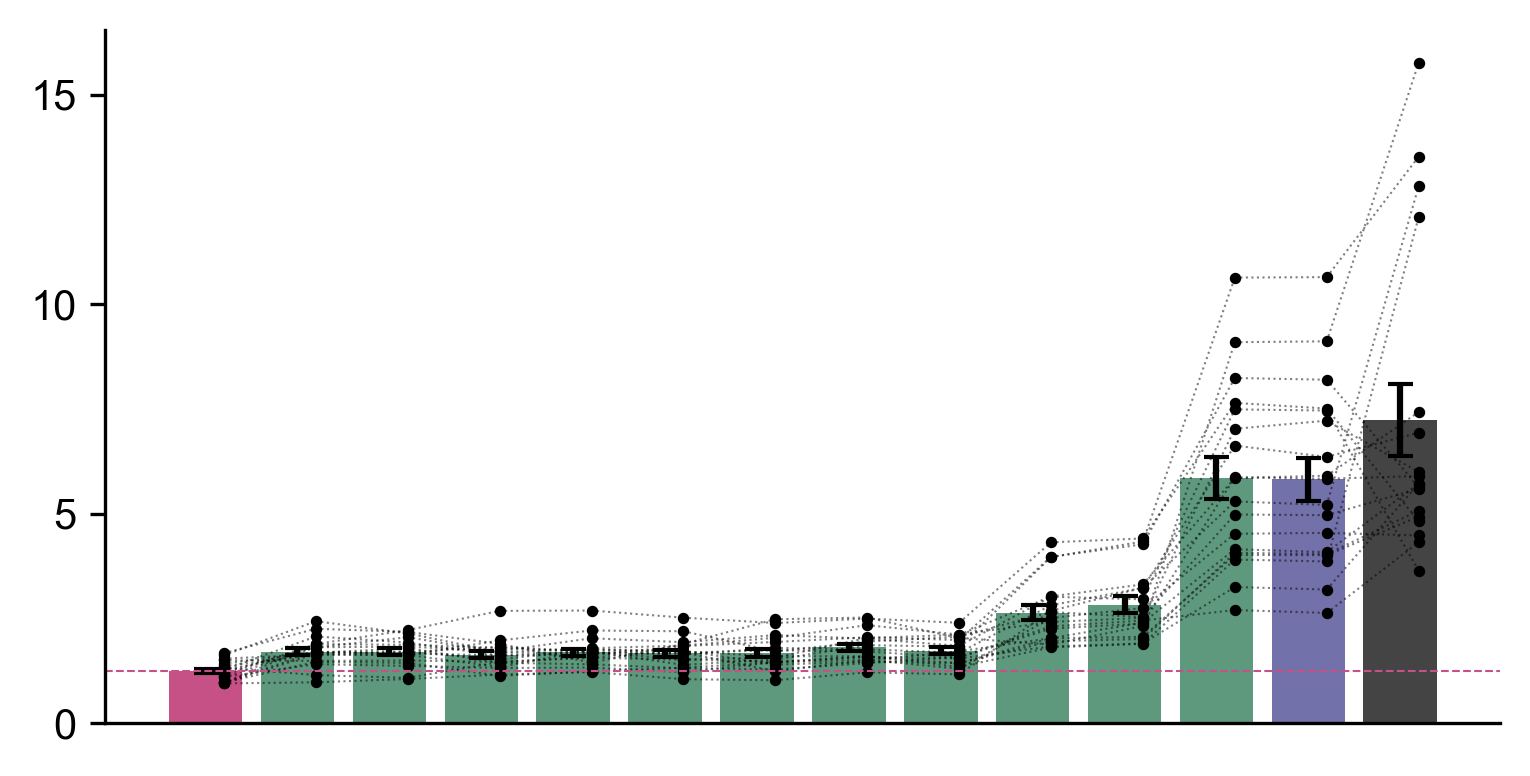

In [7]:
with open(f'../../data/error/mocet_validation_error.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for subject in subjects:
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[subject], axis=0))

with open(f'../../data/error/uncorrected_validation_error.pkl', 'rb') as f:
    uncorrected_validation_errors = pickle.load(f)
subjects_uncorrected_validation_errors = []
for subject in subjects:
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[subject], axis=0))

subjects_polynomial_validation_errors = []
for p in range(1,13):
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)
    #subjects_polynomial_calibration_errors = []
    subject_polynomial_validation_errors = []
    for subject in subjects:
        #subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subject_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[subject], axis=0))
    subjects_polynomial_validation_errors.append(subject_polynomial_validation_errors)

from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

# Define the tags for the errors
tags = ['mocet', 'polynomial', 'linear', 'uncorrected']

MSE_matrix = np.concatenate([
    np.array(subjects_mocet_validation_errors).reshape(1,-1),
    np.flip(np.array(subjects_polynomial_validation_errors), axis=0),
    np.array(subjects_uncorrected_validation_errors).reshape(1,-1)
], axis=0)
print(MSE_matrix.shape)

color_list = ['#c55187']+['#5e997d']*11+['#7371a9', '#444444']
#color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

fig, ax = plt.subplots(1, 1, figsize=(6,3), dpi=300,  sharex=True)
ax.bar(np.arange(MSE_matrix.shape[0]),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(MSE_matrix.shape[0]):
    ax.scatter(np.ones(len(subjects_mocet_validation_errors)) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(len(subjects_mocet_validation_errors)):
    for i in range(MSE_matrix.shape[0]-1):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 5, 10, 15])
ax.axhline(np.mean(MSE_matrix, axis=1)[0], c='#c55187', linestyle='--', lw=0.5)

for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [8]:
from scipy.stats import ttest_rel

with open(f'../../data/error/mocet_validation_error.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[key], axis=0))


for p in range(1, 13):
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)

    subjects_polynomial_validation_errors = []
    for key in mocet_calibration_errors.keys():
        subjects_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[key], axis=0))

    print(p, np.mean(subjects_polynomial_validation_errors), ttest_rel(subjects_mocet_validation_errors, subjects_polynomial_validation_errors))


1 5.81605242811512 TtestResult(statistic=np.float64(-8.825790479913866), pvalue=np.float64(9.345370011866534e-08), df=np.int64(17))
2 5.849214994945073 TtestResult(statistic=np.float64(-8.925268428294107), pvalue=np.float64(7.975833406838306e-08), df=np.int64(17))
3 2.826476910197833 TtestResult(statistic=np.float64(-7.055107031865186), pvalue=np.float64(1.933042555816939e-06), df=np.int64(17))
4 2.633156224322112 TtestResult(statistic=np.float64(-6.602638467775621), pvalue=np.float64(4.481338766725682e-06), df=np.int64(17))
5 1.725369399400716 TtestResult(statistic=np.float64(-5.705846299884814), pvalue=np.float64(2.5747306334534405e-05), df=np.int64(17))
6 1.8090963954041632 TtestResult(statistic=np.float64(-6.729376084848137), pvalue=np.float64(3.5310298142189687e-06), df=np.int64(17))
7 1.673969996921935 TtestResult(statistic=np.float64(-5.0110484326756835), pvalue=np.float64(0.0001070748850210534), df=np.int64(17))
8 1.6630301991003875 TtestResult(statistic=np.float64(-5.123960195